# ARX System Identification and PI Controller Design for a Quadratic Boost Converter

This document details the process of identifying a discrete-time transfer function for a quadratic boost converter using the ARX (AutoRegressive with eXogenous input) model. After identifying the model, a digital PI controller is designed and simulated in a closed-loop system with the identified plant model.

**Note for Jupyter Notebook users:** You can copy the text blocks (like this one) directly into a Markdown cell in Jupyter. The Python code blocks should be copied into Code cells.


### 1. Prerequisites and Imports

We start by importing the necessary libraries:

- `xmlrpc.client` to communicate with the PLECS simulation software.

- `matplotlib.pyplot` for creating plots.

- `numpy` for numerical computations.

- `scipy.signal` to create a discrete-time linear system (`dlti`) and simulate its step response (`dstep`).


In [12]:
import xmlrpc.client as xml
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import dlti, dstep

### 2. Data Acquisition from PLECS

A connection is established with the PLECS XML-RPC server to run a simulation and retrieve the input (`u`) and output (`y`) data from the `boost_quadratico_static` model. This data will be used for system identification.


In [13]:
# Establish connection with PLECS
plecs = xml.Server("http://localhost:9998/RPC2").plecs

# Define the PLECS model name and run the simulation
model = 'quadratic_boost_converter_arx_identification'
sim_result = plecs.simulate(model)

# Extract time, input (u), and output (y) data
time = np.array(sim_result['Time'])
u = np.array(sim_result['Values'][0])
y = np.array(sim_result['Values'][1])

### 3. ARX Model Identification

The core of this script is the ARX identification function. The ARX model structure is given by:

$y(k) + a_1 y(k-1) + ... + a_{na} y(k-na) = b_1 u(k-1) + ... + b_{nb} u(k-nb)$

We can rewrite this for prediction as:

$y(k) = -a_1 y(k-1) - ... - a_{na} y(k-na) + b_1 u(k-1) + ... + b_{nb} u(k-nb)$

This is a linear regression problem that can be expressed in matrix form as $\mathbf{Y_d} = \mathbf{\Phi} \cdot \mathbf{\theta}$, where $\mathbf{\theta} = [a_1, ..., a_{na}, b_1, ..., b_{nb}]^T$ is the vector of parameters to be estimated. The function `identify_arx_model` builds the regressor matrix $\mathbf{\Phi}$ and the output vector $\mathbf{Y_d}$ and solves for $\mathbf{\theta}$ using the method of least squares.


In [14]:
def identify_arx(y, u, na, nb):
    """
    Identifies the parameters of an ARX (AutoRegressive eXogenous) model.

    The ARX model is given by:
    y(k) = -a1*y(k-1) - ... -na*y(k-na) + b1*u(k-1) + ... + nb*u(k-nb)

    Args:
        y (np.array): The output signal.
        u (np.array): The input signal.
        na (int): The order of the autoregressive part (number of past output terms).
        nb (int): The order of the exogenous part (number of past input terms).

    Returns:
        np.array: The estimated ARX model parameters (theta).
                  The first 'na' elements are 'a' parameters,
                  and the next 'nb' elements are 'b' parameters.
    """
    N = len(y)
    Phi = []  # Regressor matrix
    Yd = []   # Output vector for identification

    # Populate the regressor matrix Phi and the output vector Yd.
    # The loop starts from max(na, nb) to ensure all past terms are available.
    for k in range(max(na, nb), N):
        # Construct the regressor vector for the current time step k.
        # It includes negative past output values and past input values.
        phi_k = [-y[k - i] for i in range(1, na + 1)] + [u[k - i] for i in range(1, nb + 1)]
        Phi.append(phi_k)
        Yd.append(y[k])

    Phi = np.array(Phi)
    Yd = np.array(Yd)

    # Solve for the parameters (theta) using the least squares method.
    # rcond=None is used to suppress a future warning in numpy's lstsq.
    theta = np.linalg.lstsq(Phi, Yd, rcond=None)[0]
    return theta

### 4. Transfer Function Representation

Once the parameters `theta` are estimated, we can construct the discrete-time transfer function $G(z)$. The function `create_and_display_transfer_function` takes the parameters and model orders to create a `dlti` (discrete-time linear time-invariant) system object from `scipy.signal` and prints the transfer function in a human-readable format.

The transfer function is:
$G(z) = \frac{B(z^{-1})}{A(z^{-1})} = \frac{b_1 z^{-1} + ... + b_{nb} z^{-nb}}{1 + a_1 z^{-1} + ... + a_{na} z^{-na}}$


In [15]:
def print_transfer_function(theta, na, nb, dt=0.0001):
    """
    Constructs and prints the discrete-time transfer function G(z)
    from the estimated ARX parameters.

    Args:
        theta (np.array): The estimated ARX model parameters.
        na (int): The order of the autoregressive part.
        nb (int): The order of the exogenous part.
        dt (float): The sampling time (default: 0.0001).

    Returns:
        scipy.signal.dlti: A discrete-time linear time-invariant system object.
    """
    # Construct the denominator polynomial A (from 'a' parameters).
    # The first coefficient is always 1 for the 'y(k)' term.
    A = np.concatenate(([1], theta[:na]))
    # Construct the numerator polynomial B (from 'b' parameters).
    # The first coefficient is 0 as there's no u(k) term in typical ARX.
    B = np.concatenate(([0], theta[na:]))

    # Create a discrete-time LTI system object.
    system = dlti(B, A, dt=dt)

    print("Polynomial A (denominator):", A)
    print("Polynomial B (numerator):", B)
    print(f"\nG(z) = ({' + '.join(f'{b:.4f}z^(-{i})' for i, b in enumerate(B))}) / ({' + '.join(f'{a:.4f}z^(-{i})' for i, a in enumerate(A))})")
    return system

### 5. Model Validation: Step Response

A common way to validate a linear model is to analyze its step response. This function calculates and plots the unit step response of the identified `dlti` system, which helps in understanding its dynamic characteristics like rise time, settling time, and overshoot.


In [16]:
def plot_step_response(system, total_time=3.0):
    """
    Plots the step response of the given discrete-time system.

    Args:
        system (scipy.signal.dlti): The discrete-time linear time-invariant system.
        total_time (float): The total simulation time for the step response in seconds.
    """
    # Calculate the number of steps required for the total simulation time.
    n_steps = int(total_time / system.dt)
    # Simulate the step response.
    _, y_out = dstep(system, n=n_steps)
    # Create the time vector for the plot.
    t = np.arange(n_steps) * system.dt
    # Squeeze the output to remove unnecessary dimensions.
    y = np.squeeze(y_out)

    plt.figure(figsize=(10, 5))
    plt.step(t, y, where='post') # Use step plot for discrete-time output.
    plt.title("ARX Model Step Response (3 seconds)")
    plt.xlabel("Time (s)")
    plt.ylabel("Output")
    plt.grid()
    plt.xlim([0, total_time]) # Set x-axis limit.
    plt.show()

### 6. PI Controller Simulation

With the plant model identified, we can now simulate a closed-loop system with a PI controller. The discrete PI controller is defined as:

$u(k) = K_p e(k) + K_i \int e(t) dt \approx K_p e(k) + K_i \sum_{j=0}^{k} e(j) \cdot T_s$

The function `simulate_pi_controller` simulates this control law. In each step `k`, it calculates the error `e[k]`, updates the control signal `u[k]`, and then uses the identified ARX model to predict the next plant output `y[k]`.


In [17]:
def simulate_pi_controller(theta, na, nb, ref=30.05, Kp=20.0, Ki=500.0, Ts=0.0001, total_time=3.0):
    """
    Simulates a closed-loop system with an ARX plant and a PI controller.

    Args:
        theta (np.array): The estimated ARX model parameters.
        na (int): The order of the autoregressive part.
        nb (int): The order of the exogenous part.
        ref (float): The reference setpoint for the PI controller.
        Kp (float): Proportional gain of the PI controller.
        Ki (float): Integral gain of the PI controller.
        Ts (float): Sampling time of the simulation.
        total_time (float): Total simulation time.
    """
    N = int(total_time / Ts) # Total number of simulation steps.
    
    # Extract ARX parameters for the specific case where na=2 and nb=1.
    # This assumes the ARX model is y(k) = -a1*y(k-1) - a2*y(k-2) + b1*u(k-1).
    a1, a2 = theta[0], theta[1]
    b1 = theta[2]

    # Initialize arrays for output (y), control action (u), and error (e).
    y = np.zeros(N)
    u = np.zeros(N)
    e = np.zeros(N)
    integral = 0 # Initialize the integral term for the PI controller.

    # Closed-loop simulation loop.
    # The loop starts from 2 because y[k-1] and y[k-2] are needed.
    for k in range(2, N):
        e[k] = ref - y[k-1]  # Calculate the error.
        integral += e[k] * Ts # Accumulate the integral of the error.
        u[k] = Kp * e[k] + Ki * integral # Calculate the PI control action.
        
        # Simulate the ARX plant based on the current control action.
        y[k] = -a1 * y[k-1] - a2 * y[k-2] + b1 * u[k-1]

    t = np.arange(N) * Ts # Create the time vector for plotting.

    # Plot the plant output and the reference.
    plt.figure(figsize=(10, 4))
    plt.plot(t, y, label='Output y')
    plt.axhline(ref, color='r', linestyle='--', label='Reference')
    plt.grid()
    plt.title("Plant Response with PI Controller")
    plt.xlabel("Time (s)")
    plt.ylabel("Output")
    plt.legend()
    plt.show()

    # Plot the control signal.
    plt.figure(figsize=(10, 4))
    plt.plot(t, u, label='Control Action u')
    plt.grid()
    plt.title("Control Signal (PI)")
    plt.xlabel("Time (s)")
    plt.ylabel("u(k)")
    plt.legend()
    plt.show()

### 7. Main Execution Block

This is where all the functions are called in sequence. We define the ARX model orders (`na=2`, `nb=1`), run the identification, display the results, and finally simulate the PI controller.


Estimated parameters: [-0.83731806 -0.16187617  0.03924773]
Polynomial A (denominator): [ 1.         -0.83731806 -0.16187617]
Polynomial B (numerator): [0.         0.03924773]

G(z) = (0.0000z^(-0) + 0.0392z^(-1)) / (1.0000z^(-0) + -0.8373z^(-1) + -0.1619z^(-2))


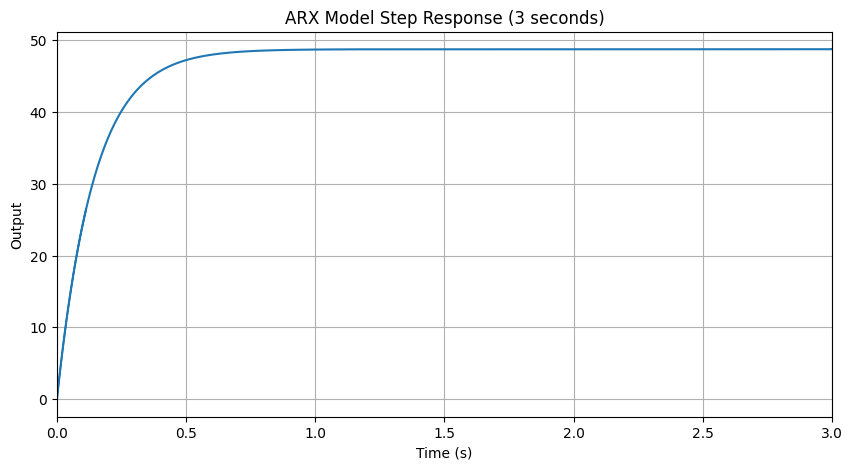

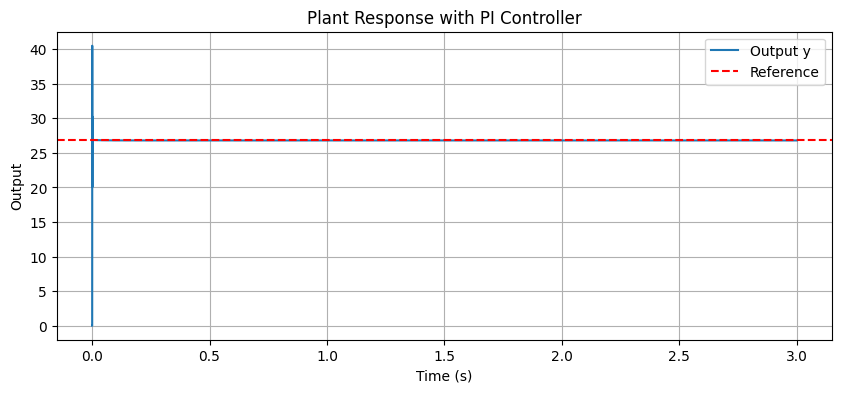

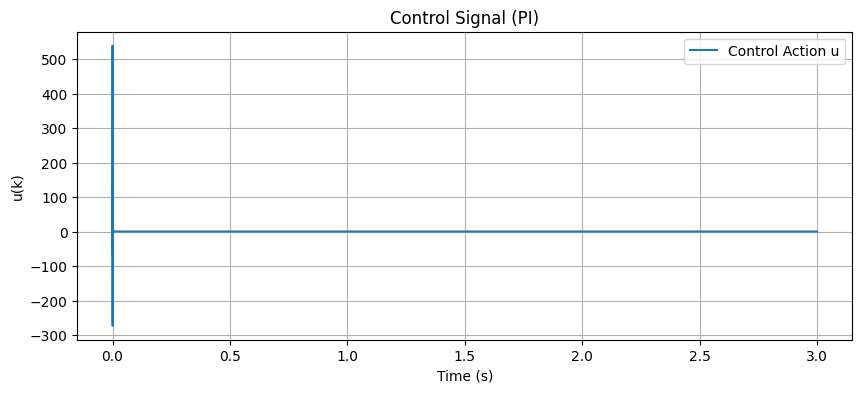

In [18]:
if __name__ == "__main__":
    # Define the orders of the ARX model.
    na, nb = 2, 1
    
    # Identify the ARX model parameters.
    theta = identify_arx(y, u, na, nb)
    print("Estimated parameters:", theta)

    # Print the transfer function and get the discrete system object.
    discrete_system = print_transfer_function(theta, na, nb, dt=0.0001)
    
    # Plot the step response of the identified ARX model.
    plot_step_response(discrete_system, total_time=3.0)

    # Simulate the system with a PI controller.
    # The reference (ref) has been adjusted from the original to match the provided value in the last line of the original code.
    simulate_pi_controller(theta, na, nb, ref=26.8, Kp=20.0, Ki=500.0, Ts=0.0001, total_time=3.0)

### 8. Conclusion

This workflow demonstrates a practical application of system identification for control design. By obtaining a mathematical model (transfer function) directly from experimental data, we can design and test a PI controller through simulation before implementing it on a real system. This process is fundamental in model-based control engineering.
